In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"satyajeetteli","key":"2bb010bef8c98781fb9c757efd508ac6"}'}

In [2]:
import os

os.makedirs("/root/.kaggle", exist_ok=True)

!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle competitions download -c digit-recognizer

 39% 6.00M/15.3M [00:00<00:00, 58.5MB/s]
100% 15.3M/15.3M [00:00<00:00, 101MB/s] 


In [5]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
import pandas as pd

# Load train and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
print(train.head())


   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [8]:
print(test.head())

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0   

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

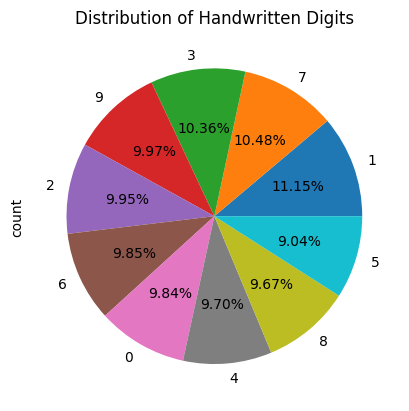

In [10]:
train['label'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.title('Distribution of Handwritten Digits')
plt.show()

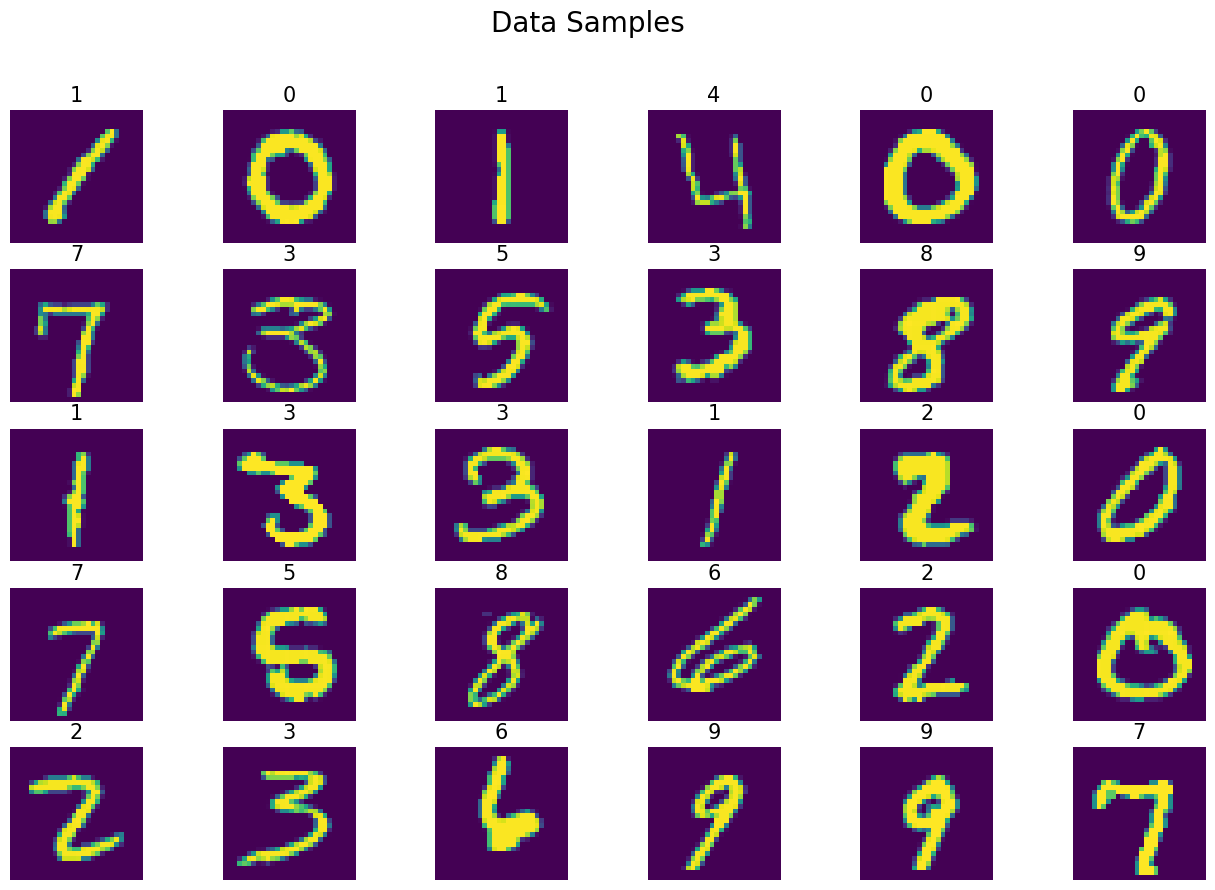

In [11]:
fig , axs = plt.subplots(nrows=5, ncols=6, figsize=(16,10))
i=0
for row in range(5):
  for col in range(6):
    axs[row][col].imshow(train.iloc[i,1:].values.reshape(28,28), cmap='viridis')
    axs[row][col].set_title(str(train.iloc[i,0]), fontsize=15)
    axs[row][col].axis('off')
    i+=1
plt.suptitle('Data Samples',fontsize=20)
plt.show()

In [12]:
#Splitting the data
y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis = 1).astype('float32')
X_test = test.astype('float32')
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

In [13]:
#reshape and covert pixel values 0 to 1 range
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_train = X_train / 255
X_test = X_test.values.reshape(-1, 28, 28, 1)
X_test = X_test / 255
X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [14]:
#one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_train.shape

(42000, 10)

In [15]:
print(train['label'].head())

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


In [16]:
print(y_train[0:5, :])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Model Creation

A little overview about the CNN:

Conv2D layers are used for two-dimensional convolutional operations. They apply a specified number of filters to small patches of the input data to detect spatial patterns like edges and textures. The first two parameters specify the number and size of the filters, and 'relu' is the activation function applied after convolution.

MaxPooling2D layers downsample the spatial dimensions of the input, reducing the number of parameters and computational load. They retain the most significant information by selecting the maximum value in each region.

Dropout layers help prevent overfitting by randomly setting a fraction of input units to zero during training. It introduces a form of regularization, making the model more robust.

Flatten layers reshape the output from the previous layer into a flat vector. They convert the spatial information from convolutional layers into a format suitable for densely connected layers.

Dense layers are fully connected layers where each neuron is connected to every neuron in the previous and next layers. They learn global patterns in the data. The first two dense layers in your model use the 'relu' activation function, while the last layer uses 'softmax' for multi-class classification.

In [17]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)),

    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'Same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'Same'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'Same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'Same'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation ='relu'),
    tf.keras.layers.Dense(256, activation ='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation ='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,922 (1.35 MB)

 Trainable params: 354,922 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
Optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.0005,
    name = 'Adam'
)

In [19]:
model.compile(optimizer = Optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
history=model.fit(X_train, y_train, batch_size = 50, epochs = 10, validation_split=0.2)

Epoch 1/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 81s 116ms/step - accuracy: 0.6841 - loss: 0.8969 - val_accuracy: 0.9725 - val_loss: 0.0871
Epoch 2/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - accuracy: 0.9695 - loss: 0.1006 - val_accuracy: 0.9854 - val_loss: 0.0430
Epoch 3/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 79s 117ms/step - accuracy: 0.9806 - loss: 0.0662 - val_accuracy: 0.9868 - val_loss: 0.0445
Epoch 4/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.9836 - loss: 0.0590 - val_accuracy: 0.9901 - val_loss: 0.0349
Epoch 5/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 84s 114ms/step - accuracy: 0.9864 - loss: 0.0439 - val_accuracy: 0.9923 - val_loss: 0.0304
Epoch 6/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.9903 - loss: 0.0347 - val_accuracy: 0.9902 - val_loss: 0.0386
Epoch 7/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.9905 - loss: 0.0313 - val_accuracy: 0.9920 - val_loss: 0.0272
Epoch 8/10
672/672 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.9924 - loss: 0

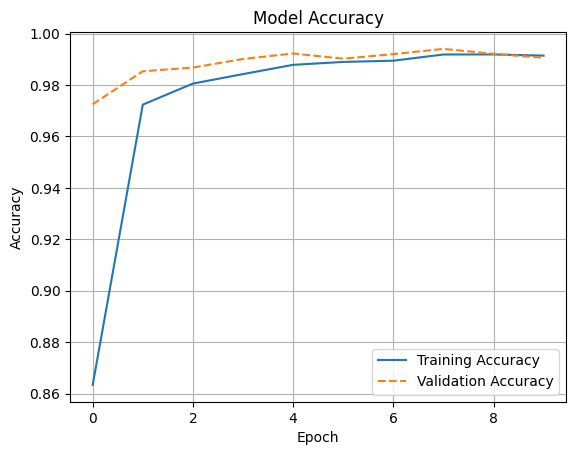

In [20]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


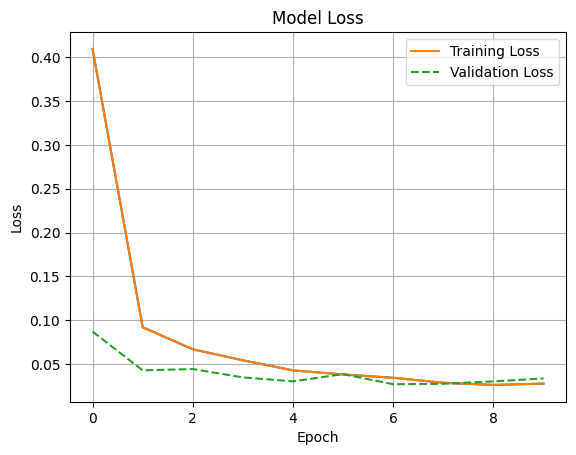

In [21]:
# Plot training loss
plt.plot(history.history['loss'])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Predicting the Values for the Test set given in competition

In [22]:
results = model.predict(X_test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = 'Label')

875/875 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step


### Submission File

In [23]:
submission = pd.concat([pd.Series(range(1, 28001), name = 'ImageId'), results], axis = 1)
submission.to_csv('submission.csv', index = False)